# Preprocessing Pipeline Demo
## Artifice vs Nature - AI Image Detection

**Environment:** AMD RX 580 (ROCm 3.5) | PyTorch 1.7.0 | Ubuntu 20.04

**Pipeline:** JPEG → Resize → Augment → Normalize → Mask → DCT

### Cell 1: Install PyTorch & torchvision from local .whl

In [1]:
# Install PyTorch 1.7.0 and torchvision 0.8.1 for ROCm 3.5
%pip install ../lib/torch-1.7.0a0-cp38-cp38-linux_x86_64.whl
%pip install ../lib/torchvision-0.8.0a0+2f40a48-cp38-cp38-linux_x86_64.whl

print("✅ PyTorch & torchvision installed successfully")

Processing /home/fadhly/comvis/2kripsi/artifice-vs-nature/lib/torch-1.7.0a0-cp38-cp38-linux_x86_64.whl
torch is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.
Processing /home/fadhly/comvis/2kripsi/artifice-vs-nature/lib/torchvision-0.8.0a0+2f40a48-cp38-cp38-linux_x86_64.whl
torchvision is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.
✅ PyTorch & torchvision installed successfully


### Cell 2: Import all required modules

In [2]:
import sys
import os

# Add parent directory to path
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import yaml

# Import preprocessing modules
from src.preprocessing import (
    apply_jpeg,
    resize_to_224,
    apply_augment,
    normalize_image,
    apply_mask,
    extract_dct_features,
    preprocess_full
)

# Import visualization
from src.utils import plot_preprocessing_pipeline

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Enable matplotlib inline
%matplotlib inline

print("\n✅ All modules imported successfully")

🖥️  Device: cuda
🎮 GPU: Ellesmere [Radeon RX 470/480/570/570X/580/580X/590]
💾 VRAM: 8.59 GB

✅ All modules imported successfully


### Cell 3: Load configuration from YAML

In [8]:
# Load preprocessing config
with open('../configs/preprocessing.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("📋 Preprocessing Configuration:")
print(yaml.dump(config, default_flow_style=False))

print("✅ Configuration loaded successfully")

📋 Preprocessing Configuration:
augmentation:
  brightness_range:
  - -0.2
  - 0.2
  contrast_range:
  - -0.2
  - 0.2
  horizontal_flip_prob: 0.5
dct:
  block_size: 8
  top_k: 1024
jpeg:
  prob: 0.7
  quality_range:
  - 30
  - 90
mask:
  ratio: 0.2
normalization:
  mean:
  - 0.485
  - 0.456
  - 0.406
  std:
  - 0.229
  - 0.224
  - 0.225

✅ Configuration loaded successfully


### Cell 4: Load sample image

**Note:** Place a sample image in `data/raw/imaginet/subset/anime/` or update the path below

📁 Using: ../data/processed/imaginet/subset/fake/ffhq_stylegan/30fe1131-325a-4f56-a73e-ab4e17a8e520.png
✅ Image loaded successfully
📐 Original size: (1024, 1024)
🎨 Mode: RGB


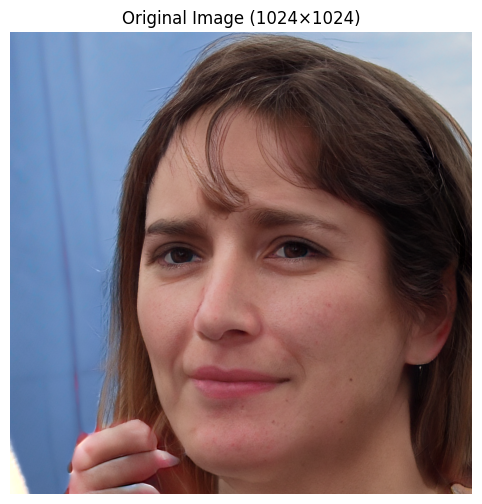

In [5]:
# Find and use an available image from the dataset
import glob

# Try to find any image in data directory
img_paths = (
    glob.glob("../data/processed/**/*.jpg", recursive=True) +
    glob.glob("../data/processed/**/*.png", recursive=True) +
    glob.glob("../data/raw/**/*.jpg", recursive=True) +
    glob.glob("../data/raw/**/*.png", recursive=True)
)

if img_paths:
    img_path = img_paths[0]
    print(f"📁 Using: {img_path}")
else:
    # Fallback: use sample path (user should place an image here)
    img_path = "../data/raw/imaginet/subset/anime/sample.jpg"
    print(f"⚠️  Default path: {img_path}")
    print("   Please place a sample image if not found")

try:
    img = Image.open(img_path)
    print(f"✅ Image loaded successfully")
    print(f"📐 Original size: {img.size}")
    print(f"🎨 Mode: {img.mode}")
    
    # Display original image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Original Image ({img.size[0]}×{img.size[1]})")
    plt.axis('off')
    plt.show()
    
except FileNotFoundError:
    print(f"❌ Image not found: {img_path}")
    print("\n💡 Please place a sample image in data directory")
except Exception as e:
    print(f"❌ Error loading image: {e}")

### Cell 5: Run full preprocessing pipeline

In [10]:
# Run full preprocessing pipeline
result = preprocess_full(img_path, config)

print("🔄 Preprocessing Pipeline Completed")
print("="*60)

# Extract results
img_masked = result['img_masked']
dct_feat = result['dct_feat']
intermediates = result['intermediates']

print(f"\n📊 Output Shapes:")
print(f"  - Masked Image: {img_masked.shape}")
print(f"  - DCT Features: {dct_feat.shape}")

print(f"\n🔍 Intermediate Results:")
print(f"  - Original size: {intermediates['original_size']}")
print(f"  - JPEG quality: {intermediates['jpeg_quality']}")
print(f"  - DCT coefficients: {len(intermediates['dct_values'])}")

print(f"\n📈 Tensor Statistics:")
print(f"  - Masked image mean: {img_masked.mean():.4f}")
print(f"  - Masked image std: {img_masked.std():.4f}")
print(f"  - DCT features mean: {dct_feat.mean():.4f}")
print(f"  - DCT features std: {dct_feat.std():.4f}")

print("\n✅ Pipeline execution successful")

🔄 Preprocessing Pipeline Completed

📊 Output Shapes:
  - Masked Image: torch.Size([3, 224, 224])
  - DCT Features: torch.Size([1024])

🔍 Intermediate Results:
  - Original size: (1024, 1024)
  - JPEG quality: 35
  - DCT coefficients: 1024

📈 Tensor Statistics:
  - Masked image mean: -0.4099
  - Masked image std: 0.7908
  - DCT features mean: 630.0394
  - DCT features std: 477.1571

✅ Pipeline execution successful


### Cell 6: Visualize preprocessing stages

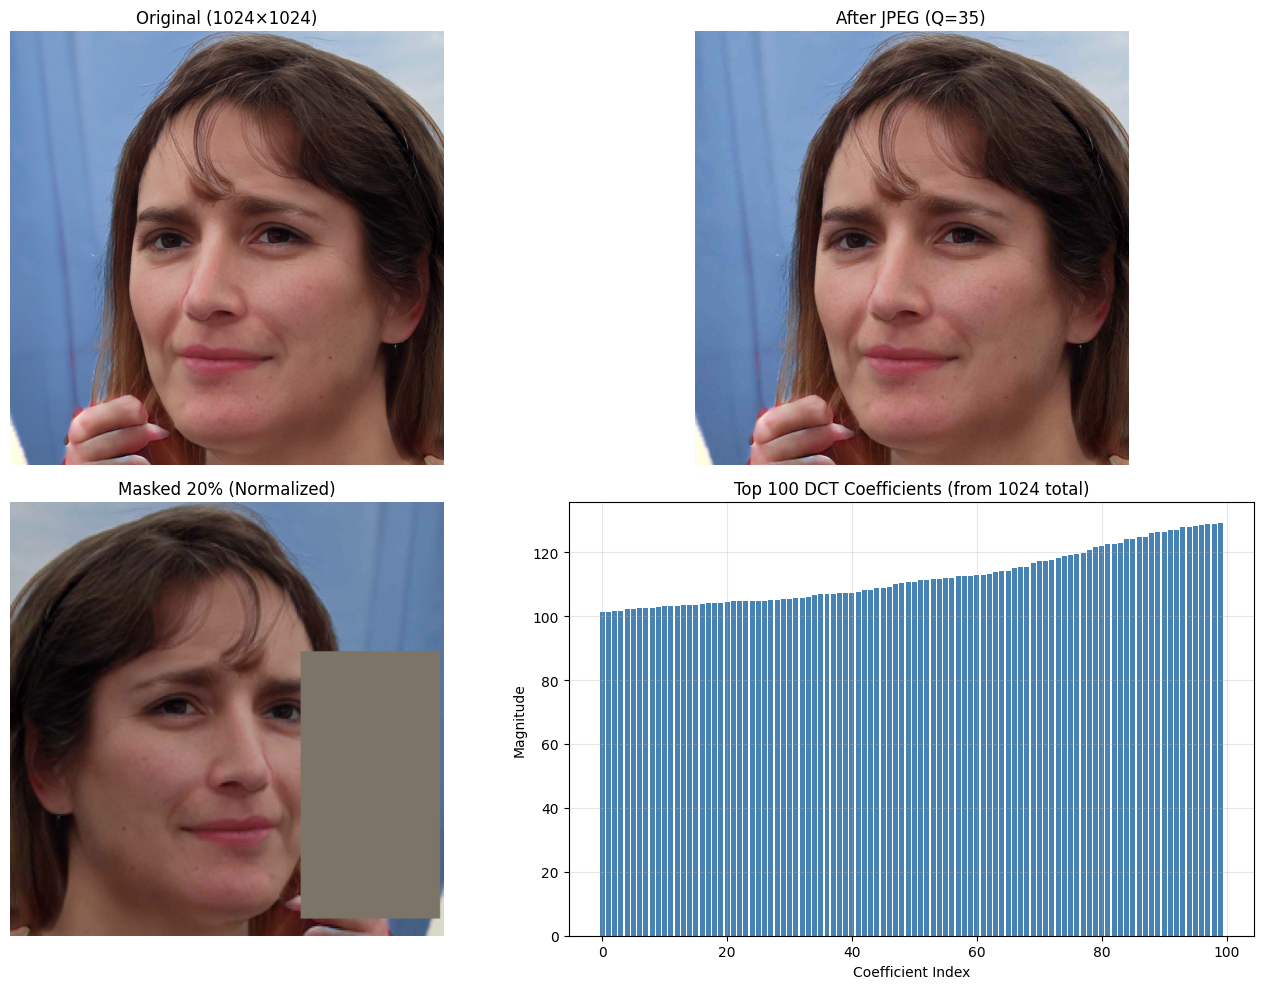

✅ Visualization complete


In [11]:
# Visualize 4-panel preprocessing pipeline
fig = plot_preprocessing_pipeline(intermediates, figsize=(14, 10))
plt.show()

print("✅ Visualization complete")

### Cell 7: Display detailed shapes and verify output

In [12]:
print("📦 Final Output Summary")
print("="*60)

print(f"\n1️⃣  Masked Image Tensor:")
print(f"   - Shape: {img_masked.shape}")
print(f"   - Dtype: {img_masked.dtype}")
print(f"   - Device: {img_masked.device}")
print(f"   - Min/Max: {img_masked.min():.4f} / {img_masked.max():.4f}")
print(f"   - Memory: {img_masked.element_size() * img_masked.nelement() / 1024:.2f} KB")

print(f"\n2️⃣  DCT Feature Vector:")
print(f"   - Shape: {dct_feat.shape}")
print(f"   - Dtype: {dct_feat.dtype}")
print(f"   - Device: {dct_feat.device}")
print(f"   - Min/Max: {dct_feat.min():.4f} / {dct_feat.max():.4f}")
print(f"   - Memory: {dct_feat.element_size() * dct_feat.nelement() / 1024:.2f} KB")

print(f"\n3️⃣  Intermediate Stages Available:")
for key in intermediates.keys():
    print(f"   - {key}")

print("\n" + "="*60)
print("✅ All preprocessing steps verified successfully!")
print("🚀 Ready for model training")

📦 Final Output Summary

1️⃣  Masked Image Tensor:
   - Shape: torch.Size([3, 224, 224])
   - Dtype: torch.float32
   - Device: cpu
   - Min/Max: -2.1179 / 1.8439
   - Memory: 588.00 KB

2️⃣  DCT Feature Vector:
   - Shape: torch.Size([1024])
   - Dtype: torch.float32
   - Device: cpu
   - Min/Max: -432.5240 / 1940.8750
   - Memory: 4.00 KB

3️⃣  Intermediate Stages Available:
   - original
   - original_size
   - jpeg
   - jpeg_quality
   - resized
   - augmented
   - normalized
   - masked
   - dct_values

✅ All preprocessing steps verified successfully!
🚀 Ready for model training


---
## Next Steps

1. **Batch Processing**: Process entire dataset using `preprocess_full()`
2. **Save Preprocessed Data**: Store in `data/processed/imaginet/subset/`
3. **Model Training**: Use `img_masked` as model input
4. **Feature Analysis**: Analyze DCT features for AI vs real patterns

---
**Project:** Artifice vs Nature | **Device:** AMD RX 580 (ROCm 3.5) | **Framework:** PyTorch 1.7.0

In [7]:
# Cell 3: Load config dari YAML
with open('../configs/preprocessing.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Config loaded:")
print(config)

Config loaded:
{'jpeg': {'prob': 0.7, 'quality_range': [30, 90]}, 'mask': {'ratio': 0.2}, 'dct': {'top_k': 1024, 'block_size': 8}, 'augmentation': {'horizontal_flip_prob': 0.5, 'brightness_range': [-0.2, 0.2], 'contrast_range': [-0.2, 0.2]}, 'normalization': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}}


In [8]:
from pathlib import Path
assert Path(img_path).exists(), f"File tidak ditemukan: {img_path}"

In [9]:
result = preprocess_full(img_path, config)

print("Preprocessing selesai!")
print(f"img_masked shape: {result['img_masked'].shape}")
print(f"dct_feat   shape: {result['dct_feat'].shape}")

Preprocessing selesai!
img_masked shape: torch.Size([3, 224, 224])
dct_feat   shape: torch.Size([1024])


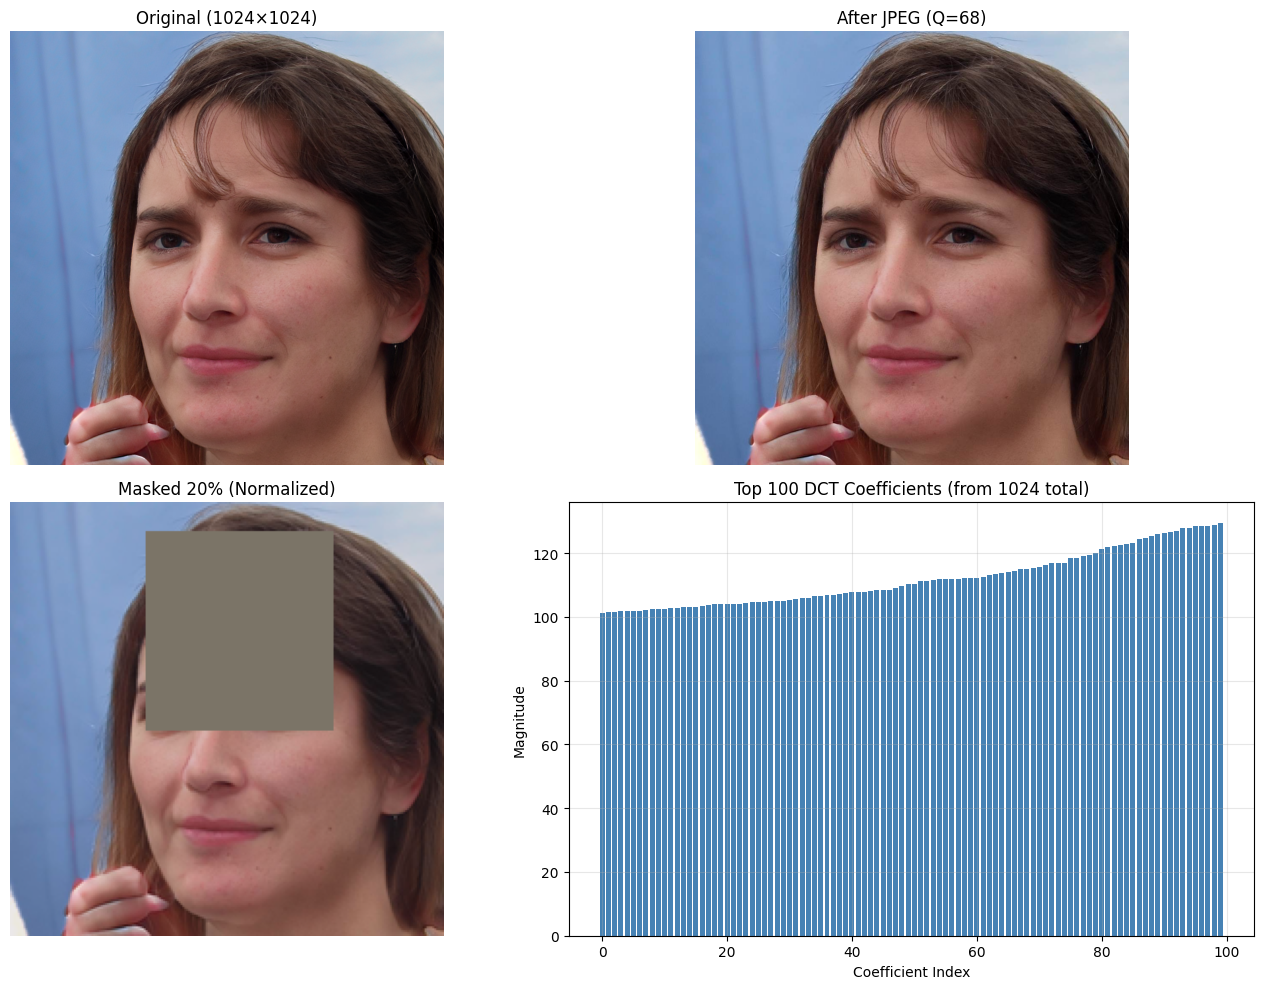

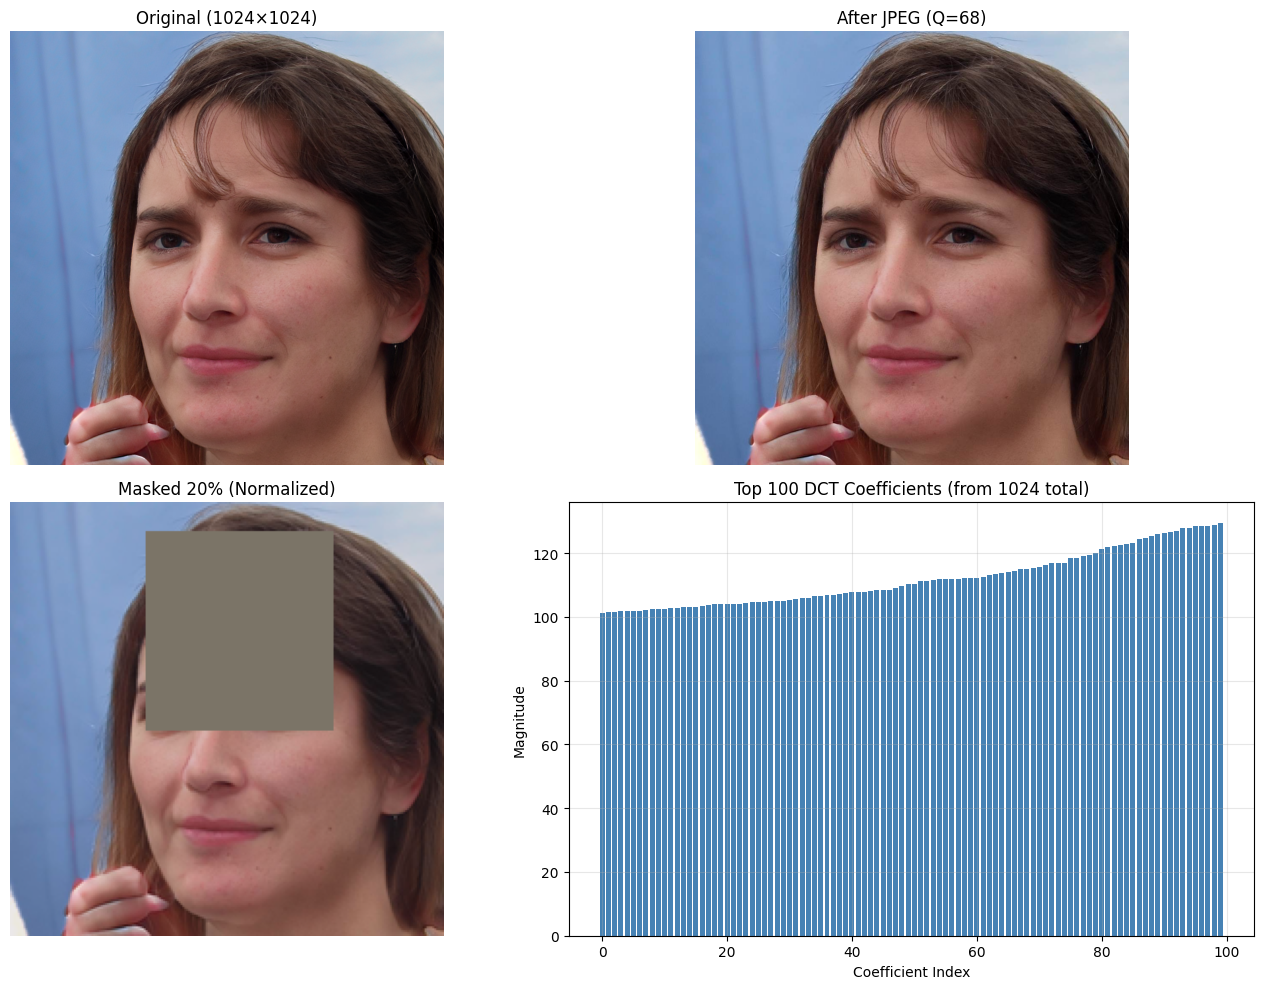

In [10]:
%matplotlib inline
plot_preprocessing_pipeline(result['intermediates'])